In [ ]:
import os
import ROOT
import pandas as pd
import PyRDF
import numpy as np

## Process raw information from DIGI ntuplizer

In [ ]:
def processDigis(url='/eos/cms/store/cmst3/user/psilva/HGCAL/test.root',ran=None, minmips=1.0):
    
    """
    collects all the relevant information on event by event basis
    url - location of the file
    ran - event range (a,b)
    minmips - minmimump simulated mips required
    """
    
    ROOT.ROOT.EnableImplicitMT()
    rdf = ROOT.RDataFrame("ana/hits", url)
    
    #filter event range if required
    if not ran is None:
        rdf=rdf.Filter('event>={} && event<={}'.format(*ran))

    #filter the hits (at least 1 simulated MIP deposit)    
    rdf=rdf.Filter(f'mipsim>={minmips}')
    
    #helper variables
    #here the vertex corrected ToA could be defined already
    rdf=rdf.Define('side','z<0 ? -1 : 1'). \
            Define('waferroc','roc+1000*u+1000000*v')  # just a dummy unique indexing
    
    #convert to a pandas dataframe which is easier to manipulate
    #keep 
    columns=['event','side','layer','roc','gpt','geta','mipsim','toarec']
    df=pd.DataFrame( rdf.AsNumpy(columns), columns=columns )
    df.to_hdf(url.replace('.root','.h5'),key='hits')
    print('\tFilled with',df.shape[0],'hits to analyze from',len(df['event'].unique()),'events')
        
    return df

In [3]:
%%time
df=processDigis()

	Filled with 17731676 hits to analyze from 49993 events
CPU times: user 27.6 s, sys: 3.99 s, total: 31.6 s
Wall time: 39.8 s


In [10]:
%%time

#select the hits from where to compute the final ToA estimator
selmips=(df['mipsim']>1) & (df['toarec']>0)
df['selmips']=np.where(selmips,df['mipsim'],np.zeros(df.shape[0]))
df['seltoa']=np.where(selmips,df['toarec'],np.zeros(df.shape[0]))
df['mipsimtoa']=df['selmips']*df['seltoa']

#aggregate by event and finalize average
summary_df=df.groupby('event').agg(gpt=('gpt','mean'),
                                   geta=('geta','mean'),
                                   totalmips=('selmips','sum'),
                                   totaltoa=('mipsimtoa','sum'),
                                   avgtoa=('seltoa','mean'))
summary_df['mipavgtoa']=summary_df['totaltoa']/summary_df['totalmips']

summary_df.head()

CPU times: user 1.91 s, sys: 1.13 s, total: 3.03 s
Wall time: 2.62 s


,gpt,geta,totalmips,totaltoa,avgtoa,mipavgtoa
event,,,,,,
1,12.146950,2.000486,4011.705240,17621.984053,1.860807,4.392642
2,8.260753,1.999453,688.796636,2649.599305,1.872099,3.846708
3,5.104912,1.999826,724.788654,1840.928129,0.664366,2.539952
4,14.758848,1.999974,2954.904526,9434.431375,0.960392,3.192804
5,7.902452,2.000279,865.618412,3265.476774,1.543300,3.772421


## Plotting

/tmp/ipykernel_576/1745120345.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  summary_binned=summary_df.groupby('ptbin')['avgtoa','mipavgtoa'].agg(['mean','sem'])


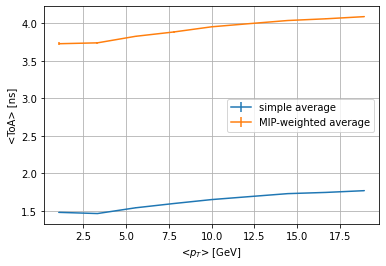

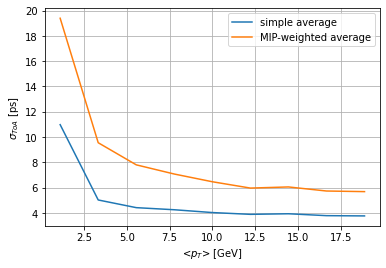

In [24]:
import matplotlib.pyplot as plt


#profile the toa in ptbins
bins = np.linspace(0, 20, 10)
summary_df['ptbin'] = np.digitize(summary_df['gpt'], bins=bins)
summary_binned=summary_df.groupby('ptbin')['avgtoa','mipavgtoa'].agg(['mean','sem'])
summary_binned['pt'] = 0.5 * (bins[:-1] + bins[1:])

#bias
plt.errorbar(x=summary_binned['pt'],y=summary_binned[('avgtoa','mean')],yerr=summary_binned[('avgtoa','sem')],label='simple average',fmt='')
plt.errorbar(x=summary_binned['pt'],y=summary_binned[('mipavgtoa','mean')],yerr=summary_binned[('mipavgtoa','sem')],label='MIP-weighted average',fmt='')
plt.legend()
plt.xlabel(r'<$p_{T}$> [GeV]')
plt.ylabel('<ToA> [ns]')
plt.grid()
plt.show()

#resolution
plt.errorbar(x=summary_binned['pt'],y=summary_binned[('avgtoa','sem')]*1e3,label='simple average',fmt='')
plt.errorbar(x=summary_binned['pt'],y=summary_binned[('mipavgtoa','sem')]*1e3,label='MIP-weighted average',fmt='')
plt.legend()
plt.xlabel(r'<$p_{T}$> [GeV]')
plt.ylabel('$\sigma_{ToA}$ [ps]')
plt.grid()
plt.show()